### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

1) $ - \frac{\partial{L}}{\partial{a}} = 2 (y_i - a(x_i)) $

2) $ - \frac{\partial{L}}{\partial{a}} = y_i exp( -a(x_i) y_i ) $

3) $ - \frac{\partial{L}}{\partial{a}} = \frac{y_i}{1 + exp( a(x_i) y_i )} $

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

plt.style.use('ggplot')

In [2]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.1, n_estimators=100,
                 colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов: 'mse', 'exponential', 'deviance'
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.init_model = None
        self.models = []
        self.attr_indices = []
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        if init_model is not None:
            self.init_model = init_model()
            self.init_model.fit(X, y)
            f = self.init_model.predict(X)
        else:
            f = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            x_idx = np.random.choice(X.shape[0], round(X.shape[0] * self.subsample), replace=False)
            attr_idx = np.random.choice(X.shape[1], round(X.shape[1] * self.colsample), replace=False)
            self.attr_indices.append(attr_idx)
            X_sample = np.array(X[x_idx])
            X_sample = X_sample[:, attr_idx]
            y_sample = y[x_idx]
            f_prev = f[x_idx]
            if self.loss == 'mse':
                target = 2 * (y_sample - f_prev)
            elif self.loss == 'exponential':
                target = y_sample * np.exp(-f_prev * y_sample)
            elif self.loss == 'deviance':
                target = y_sample / (1 + np.exp(f_prev * y_sample))
            else:
                raise ValueError('Invalid loss: "' + self.loss + '"')
            self.models.append(base_model(*self.args, **self.kwargs))
            self.models[-1].fit(X_sample, target)
            f[x_idx] += self.learning_rate * self.models[-1].predict(X_sample)
            
        
    def predict(self, X):
        if self.init_model is None:
            y = np.zeros(X.shape[0])
        else:
            y = np.asarray(self.init_model.predict(X))
        sum_f = np.zeros(X.shape[0])
        for k, f_k in enumerate(self.models):
            sum_f += f_k.predict(X[:, self.attr_indices[k]])
        y += self.learning_rate * sum_f
        y = y.round()
        return y


In [3]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [7]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [8]:
y = (y - 0.5) * 2
y

array([ 1.,  1.,  1., ..., -1., -1., -1.])

In [9]:
def mean_val_score(clf, X, y, n_splits=5, *args, **kwargs):
    scores = []
    kf = StratifiedKFold(n_splits=n_splits)
    for train, test in kf.split(X, y):
        clf.fit(X[train], y[train], **kwargs)
        y_pred = clf.predict(X[test])
        y_pred[y_pred >= 0] = 1
        y_pred[y_pred < 0] = -1
        scores.append(accuracy_score(y_pred=y_pred, y_true=y[test]))
    return np.mean(scores)

In [10]:
n_grid = np.arange(50, 150, 10, dtype=np.int)
scores_1 = {'mse' : [],
          'exponential': [],
          'deviance': []}

for loss in scores_1:
    for n in tqdm(n_grid):
        my_clf = MyGradientBoostingClassifier(loss=loss, n_estimators=n)
        scores_1[loss].append(mean_val_score(my_clf, X, y, n_splits=3))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

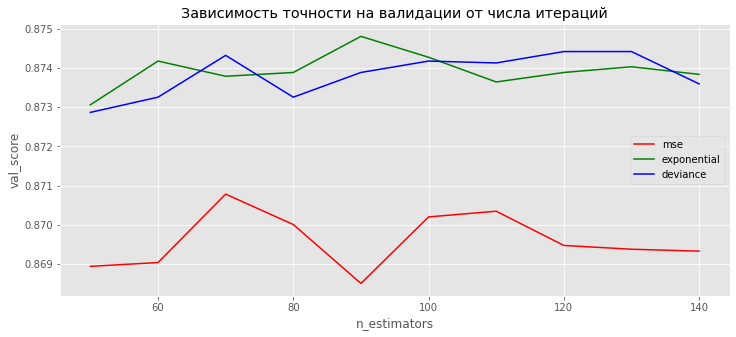

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_ylabel('val_score')
ax1.set_xlabel('n_estimators')
ax1.set_title('Зависимость точности на валидации от числа итераций')
fig.set_figheight(5)
fig.set_figwidth(12)
colors = ['r', 'g', 'b']

for i, loss in enumerate(scores_1):
    ax1.legend(loss)
    ax1.plot(n_grid, scores_1[loss], c=colors[i], label=loss)
    
ax1.legend()

In [13]:
#learning_rate

learning_rate_grid = np.logspace(1, -3, 6)
scores_2 = {'mse' : [],
          'exponential': [],
          'deviance': []}

for loss in scores_2:
    for learning_rate in tqdm(learning_rate_grid):
        my_clf = MyGradientBoostingClassifier(loss=loss, learning_rate=learning_rate)
        scores_2[loss].append(mean_val_score(my_clf, X, y, n_splits=3))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

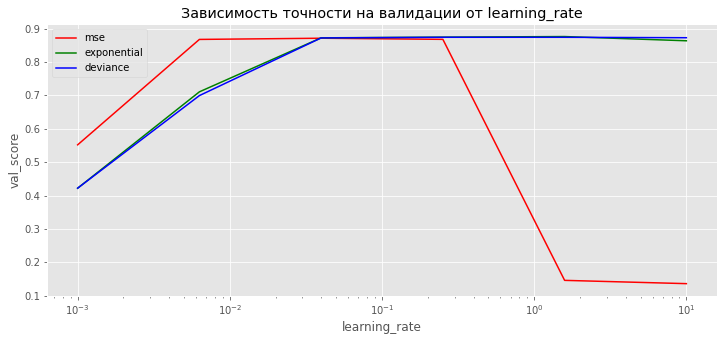

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_ylabel('val_score')
ax1.set_xlabel('learning_rate')
ax1.set_title('Зависимость точности на валидации от learning_rate')
fig.set_figheight(5)
fig.set_figwidth(12)
colors = ['r', 'g', 'b']

for i, loss in enumerate(scores_2):
    ax1.legend(loss)
    ax1.plot(learning_rate_grid, scores_2[loss], c=colors[i], label=loss)

ax1.set_xscale('log')
ax1.legend()

In [17]:
#colsample

colsample_grid = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.0])
scores_3 = {'mse' : [],
          'exponential': [],
          'deviance': []}

for loss in scores_3:
    for colsample in tqdm(colsample_grid):
        my_clf = MyGradientBoostingClassifier(loss=loss, colsample=colsample)
        scores_3[loss].append(mean_val_score(my_clf, X, y, n_splits=3))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

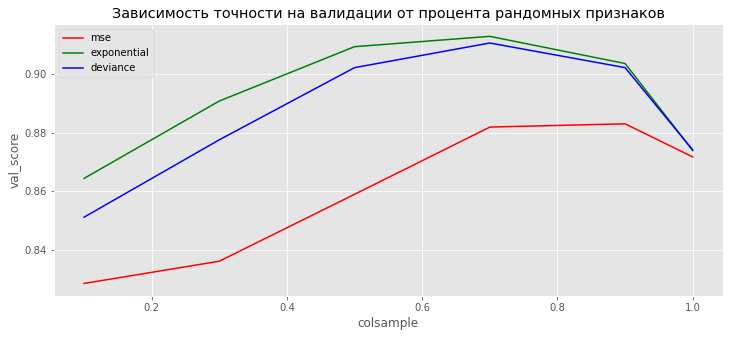

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_ylabel('val_score')
ax1.set_xlabel('colsample')
ax1.set_title('Зависимость точности на валидации от процента рандомных признаков')
fig.set_figheight(5)
fig.set_figwidth(12)
colors = ['r', 'g', 'b']

for i, loss in enumerate(scores_3):
    ax1.legend(loss)
    ax1.plot(colsample_grid, scores_3[loss], c=colors[i], label=loss)

ax1.legend()

In [19]:
#subsample

subsample_grid = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.0])
scores_4 = {'mse' : [],
          'exponential': [],
          'deviance': []}

for loss in scores_4:
    for subsample in tqdm(subsample_grid):
        my_clf = MyGradientBoostingClassifier(loss=loss, subsample=subsample)
        scores_4[loss].append(mean_val_score(my_clf, X, y, n_splits=3))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

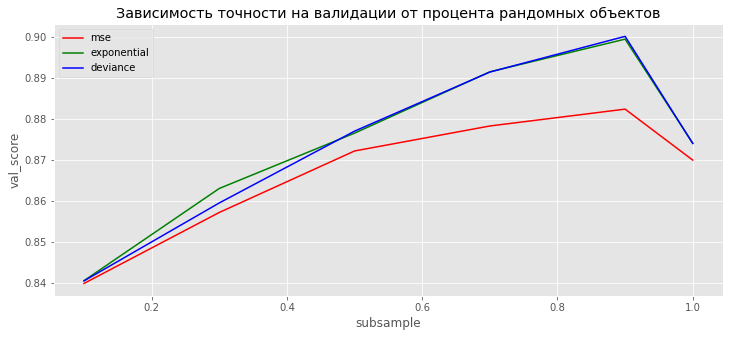

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_ylabel('val_score')
ax1.set_xlabel('subsample')
ax1.set_title('Зависимость точности на валидации от процента рандомных объектов')
fig.set_figheight(5)
fig.set_figwidth(12)
colors = ['r', 'g', 'b']

for i, loss in enumerate(scores_4):
    ax1.legend(loss)
    ax1.plot(colsample_grid, scores_4[loss], c=colors[i], label=loss)

ax1.legend()

In [24]:
best_loss = 'deviance'
best_n_estimators = 100
best_learning_rate = 0.1
best_colsample = 0.7
best_subsample = 0.9

In [22]:
my_clf = MyGradientBoostingClassifier(loss=best_loss, n_estimators=best_n_estimators,
                                      learning_rate=best_learning_rate,
                                      colsample=best_colsample,
                                      subsample=best_subsample)
print('Лучшее качество на валидации:', mean_val_score(my_clf, X, y, n_splits=3))

Лучшее качество на валидации: 0.9164728682170543


## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [25]:
boo_bag_scores = {'mse' : 0,
          'exponential': 0,
          'deviance': 0}

for loss in tqdm(boo_bag_scores):
    my_clf = MyGradientBoostingClassifier(loss=loss, n_estimators=best_n_estimators,
                                      learning_rate=best_learning_rate,
                                      colsample=best_colsample,
                                      subsample=best_subsample,
                                      max_depth=6, n_jobs=-1)
    boo_bag_scores[loss] = mean_val_score(my_clf, X, y, n_splits=3, base_model=RandomForestRegressor)

for _, loss in enumerate(boo_bag_scores):
    print(loss + ':', boo_bag_scores[loss])

  0%|          | 0/3 [00:00<?, ?it/s]

mse: 0.8497577519379845
exponential: 0.8416666666666667
deviance: 0.8379360465116279


In [28]:
def vote(x):
    counts = np.unique(x, return_counts=True)
    return counts[0][np.argmax(counts[1])]


N = 50
scores = []
kf = StratifiedKFold(n_splits=3)
for train, test in kf.split(X, y):
    y_preds = np.zeros((y[test].shape[0], N))
    for i in tqdm(range(N)):
        my_clf = MyGradientBoostingClassifier(loss=best_loss, n_estimators=best_n_estimators,
                                              learning_rate=best_learning_rate,
                                              colsample=best_colsample,
                                              subsample=best_subsample)
        n = X[train].shape[0]
        indices = np.random.choice(n, round(n / N), replace=False)
        X_sub = X[train]
        X_sub = X_sub[indices]
        y_sub = y[indices]
        my_clf.fit(X_sub, y_sub)
        y_pred = my_clf.predict(X[test])
        y_pred[y_pred >= 0] = 1
        y_pred[y_pred < 0] = -1
        y_preds[:, i] = y_pred
    y_res = np.apply_along_axis(vote, axis=1, arr=y_preds)
    scores.append(accuracy_score(y_pred=y_res, y_true=y[test]))
bag_boo_score = np.mean(scores)

print('BagBoo score:', bag_boo_score)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BagBoo score: 0.7056686046511628


Прироста качества нет. Возможно, если попробовать настроить параметры - результат будет лучше.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [35]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [30]:
#LinearRegression

lin_reg_scores = {'mse' : 0,
          'exponential': 0,
          'deviance': 0}

for loss in tqdm(lin_reg_scores):
    my_clf = MyGradientBoostingClassifier(loss=loss, n_estimators=best_n_estimators,
                                      learning_rate=best_learning_rate,
                                      colsample=best_colsample,
                                      subsample=best_subsample)
    lin_reg_scores[loss] = mean_val_score(my_clf, X, y, n_splits=3, base_model=LinearRegression)

for _, loss in enumerate(lin_reg_scores):
    print(loss + ':', lin_reg_scores[loss])

  0%|          | 0/3 [00:00<?, ?it/s]

mse: 0.7802810077519379
exponential: 0.8007751937984495
deviance: 0.8046511627906976


In [31]:
#KNeighborsRegressor

knn_scores = {'mse' : 0,
          'exponential': 0,
          'deviance': 0}

for loss in tqdm(knn_scores):
    my_clf = MyGradientBoostingClassifier(loss=loss, n_estimators=best_n_estimators,
                                      learning_rate=best_learning_rate,
                                      colsample=best_colsample,
                                      subsample=best_subsample)
    knn_scores[loss] = mean_val_score(my_clf, X, y, n_splits=3, base_model=KNeighborsRegressor)

for _, loss in enumerate(knn_scores):
    print(loss + ':', knn_scores[loss])

  0%|          | 0/3 [00:00<?, ?it/s]

mse: 0.7577519379844961
exponential: 0.8423934108527131
deviance: 0.8086724806201552


In [ ]:
#SVR

svr_scores = {'mse' : 0,
          'exponential': 0,
          'deviance': 0}

for loss in tqdm(svr_scores):
    my_clf = MyGradientBoostingClassifier(loss=loss, n_estimators=best_n_estimators,
                                      learning_rate=best_learning_rate,
                                      colsample=best_colsample,
                                      subsample=best_subsample)
    svr_scores[loss] = mean_val_score(my_clf, X, y, n_splits=3, base_model=SVR)

for _, loss in enumerate(svr_scores):
    print(loss + ':', svr_scores[loss])

Прироста качества нет. Возможно, это из-за того, что базовые алгоритмы тоже нужно настраивать.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

